In [23]:
# Import or install Sionna
try:
    import sionna.rt
except ImportError as e:
    import os
    os.system("pip install sionna-rt")
    import sionna.rt


# Other imports
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import mitsuba as mi

no_preview = False # Toggle to False to use the preview widget

# Import relevant components from Sionna RT
from sionna.rt import load_scene, PlanarArray, Transmitter, Receiver, Camera,\
                      PathSolver, RadioMapSolver, subcarrier_frequencies, SceneObject,ITURadioMaterial,cpx_abs_square


In [24]:
scene = load_scene(sionna.rt.scene.munich, merge_shapes=True) # Merge shapes to speed-up computations


In [25]:

# Configure antenna array for all transmitters
scene.tx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="iso",
                             polarization="V")

# Configure antenna array for all receivers
scene.rx_array = PlanarArray(num_rows=1,
                             num_cols=1,
                             vertical_spacing=0.5,
                             horizontal_spacing=0.5,
                             pattern="dipole",
                             polarization="cross",
                             )

# Create transmitter
# tx = Transmitter(name="tx",
#                  position=[50,100,20],
#                  display_radius=2,
#                  power_dbm = 20
#                 )
rx = Receiver('rx',position=[50,100,20],display_radius=2)

# tx2 = Transmitter(name="tx2",
#                  position=[300,400,20],
#                  display_radius=2,
#                 )

# tx3 = Transmitter(name="tx3",
#                  position=[-200,-100,100],
#                  display_radius=2,
                # )
# Add transmitter instance to scene
scene.remove('rx')
scene.add(rx)
# scene.add(tx2)
# scene.add(tx3)

for i in range(5):
    scene.remove(f'tx-{i}')
    scene.add(Transmitter(f'tx-{i}',position=[70,  50+i*15, 10],display_radius=2))






In [31]:
p_solver = PathSolver()
paths = p_solver(scene=scene,
                 max_depth=3,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=True,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)

In [32]:
scene.preview(paths=paths);

In [33]:
a,_ = paths.cir(normalize_delays = False, out_type = 'numpy')
a.shape

(1, 2, 5, 1, 31, 1)

In [ ]:

car_material = ITURadioMaterial("car-material",
                                "metal",
                                thickness=0.01,
                                color=(0.8, 0.1, 0.1))

car = SceneObject(fname = sionna.rt.scene.low_poly_car, name = 'car1',radio_material = car_material)
car_pos_x = 40
car_pos_y = 90
car_pos_z = 1
scene.edit(add = [car])
car.position = mi.Point3f(car_pos_x,car_pos_y,car_pos_z)
# Create a receiver
rx = Receiver(name="rx",
              position=[car_pos_x,car_pos_y,car_pos_z+2],
              display_radius=2)

    # Add receiver instance to scene
scene.add(rx)
displacement_vec = [2,0,0]
for i in range(50):


    p_solver  = PathSolver()

    # Compute propagation paths
    paths = p_solver(scene=scene,
                 max_depth=2,
                 los=True,
                 specular_reflection=True,
                 diffuse_reflection=False,
                 refraction=True,
                 synthetic_array=False,
                 seed=41)
    a,_ = paths.cir(normalize_delays = False, out_type = 'numpy')
    scene.render_to_file(camera="preview",
                         filename=f"frame{i}.png",
                         resolution=[650,500],paths = paths);
    path_powers = np.abs(a)**2
    total_power = np.sum(path_powers)  
    print("Gain", total_power)
    print("Gain (dB):", 10 * np.log10(total_power))
    scene.get('car1').position += displacement_vec
    scene.get('rx').position +=displacement_vec



In [77]:
rm_solver = RadioMapSolver()

rm = rm_solver(scene = scene,
               max_depth = 5,
               cell_size = [1,1],
               samples_per_tx = 10**7,
               center=[0,0,0.1],
               orientation=[0,0,0],
               size = [1000,1000])
if no_preview:
    scene.render(camera=my_cam, paths=paths, clip_at=20);
else:
    scene.preview(radio_map = rm,paths=paths, clip_at=20);

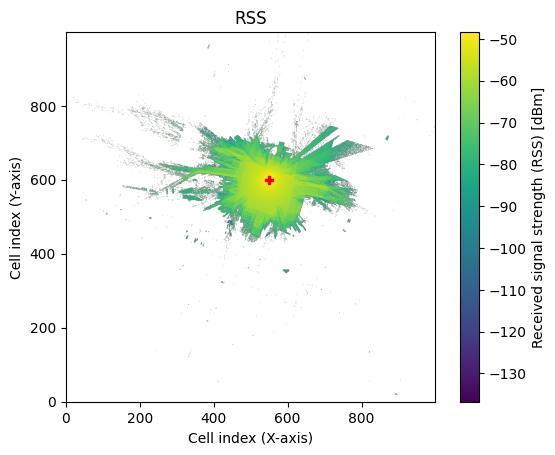

In [75]:
rm.show(metric="rss");

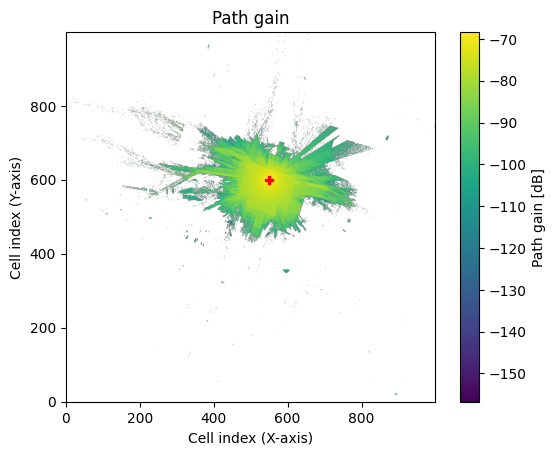

In [76]:
rm.show(metric="path_gain");


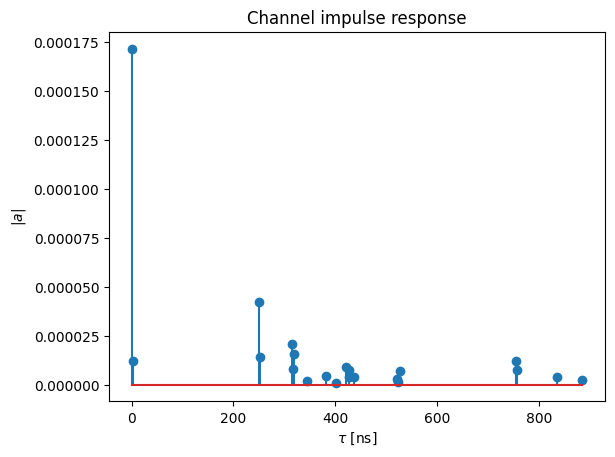

In [8]:
t = tau[0,0,0,0,:]/1e-9 # Scale to ns
a_abs = np.abs(a)[0,0,0,0,:,0]
a_max = np.max(a_abs)

# And plot the CIR
plt.figure()
plt.title("Channel impulse response")
plt.stem(t, a_abs)
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$");